In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import deeplab.network as network
import torchvision.transforms.functional as FUNC

from PIL import Image
from sklearn.manifold import TSNE
from torch.utils.data import Dataset
from matplotlib.colors import ListedColormap
from torchvision.transforms import RandomCrop

In [2]:
class NormedConv(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, scale=1.0, margin=0.0, dilation=1, groups=1, bias=False, padding_mode='zeros', device=None, dtype=None):
        super(NormedConv, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, padding_mode, device=device, dtype=dtype)
        self.scale = scale
        self.margin = margin

    def forward(self, x):
        # Normalizza i pesi lungo la dimensione dei filtri (output channels)
        norm_weight = F.normalize(self.weight, p=2, dim=1)
        # Normalizza l'input lungo la dimensione dei canali (dim=1)
        norm_x = F.normalize(x, p=2, dim=1)
        # Chiama il forward con input e pesi normalizzati
        return self.scale * F.conv2d(norm_x, norm_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


In [4]:
device = 'cuda:6'
weight_path = "/raid/homespace/piecestola/space/ML4CV/results_4/train_4/ckpts/weights_mIoU_1.pt"

model = network.modeling.__dict__['deeplabv3plus_resnet101'](num_classes=23, output_stride=16)

#model.classifier.classifier[3] = nn.Conv2d(256, 13, kernel_size=(1, 1), stride=(1, 1))
model.classifier.classifier[3] = NormedConv(256, 13, kernel_size=(1, 1), stride=(1, 1))

model.load_state_dict(torch.load(weight_path, map_location=device)['model_state_dict'])
#model.load_state_dict(torch.load(weight_path, map_location=device))

model.to(device)
model.eval()
print()

In [5]:
class ToTensorSync:
    def __call__(self, img, mask):
        # Converti l'immagine in un tensore normalizzato
        img_tensor = FUNC.to_tensor(img)
        
        # Converti la maschera in un tensore grezzo senza normalizzazione
        mask_tensor = FUNC.pil_to_tensor(mask)
        
        return img_tensor, mask_tensor
    
class NormalizeSync:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img, mask):
        img = FUNC.normalize(img, mean=self.mean, std=self.std)
        return img, mask
        
class ComposeSync:
    """
    Composizione di trasformazioni che accettano immagine e maschera.
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        for transform in self.transforms:
            img, mask = transform(img, mask)
        return img, mask

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transforms=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transforms = transforms
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transforms:
            image, mask = self.transforms(image, mask)

        mask = mask.squeeze()
        mask = mask.type(torch.int64)-1

        return image, mask
    
path_test = './data/test'
path_test_images            =  path_test + '/images/test/t5'
path_test_masks             =  path_test + '/annotations/test/t5'
path_test_anomaly_images    =  path_test + '/images/test/t6'
path_test_anomaly_masks     =  path_test + '/annotations/test/t6'

# Trasformazioni
transforms = ComposeSync([
    ToTensorSync(),
    NormalizeSync(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Training dataset
dataset_test = SegmentationDataset(
    images_dir = path_test_anomaly_images,
    masks_dir = path_test_anomaly_masks,
    transforms = transforms
)

In [6]:
image, mask = dataset_test[0]
image = image.unsqueeze(dim=0).to(device)
mask = mask.cpu().detach().numpy()

torch.Size([256, 320])
Classe 2 non presente
Classe 4 non presente
Classe 10 non presente
Classe 12 non presente


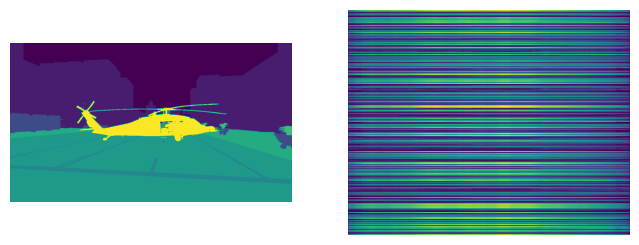

In [ ]:
# Funzione per catturare l'input del layer
def hook_fn(module, input, output):
    global layer_input
    layer_input = input[0]  # `input` è una tupla; prendiamo il primo elemento


# Registra l'hook sul livello desiderato
handle = model.classifier.classifier[3].register_forward_hook(hook_fn)

with torch.no_grad():
    logits = model(image).squeeze()
    #indices = torch.linalg.norm(layer_input,dim=2)
    #indices = -torch.sum(torch.softmax(logits,dim=0)*torch.log(torch.softmax(logits,dim=0)+0.0000001),dim=0)
    #indices = torch.argmax(logits,dim=0)
    indices = logits

handle.remove()

layer_input = torch.nn.functional.interpolate(layer_input.cpu().detach(), size=(4 * layer_input.shape[2], 4 * layer_input.shape[3]), mode='nearest')
layer_input = layer_input.squeeze(0)
layer_input = layer_input.numpy()
layer_input = layer_input.transpose((1,2,0))

#logits = logits.permute((1,2,0)).cpu().detach().numpy()
indices = indices.cpu().detach().numpy()

N = 500
vectors = list()
classes = list()
for i in range(14):
    temp = layer_input[mask==i][:N]
    if temp.shape[0]:
        vectors.append(temp)
        classes.append(i*np.ones(shape=temp.shape[0],dtype=np.int32))
    else:
        print(f"Classe {i} non presente")
vectors = np.concatenate(vectors)
classes = np.concatenate(classes)

fig, axs = plt.subplots(1,2,figsize=(8,6))
axs[0].imshow(mask)
axs[0].axis('off')
axs[1].imshow(indices)
axs[1].axis('off')
plt.show()

/raid/homespace/piecestola/.conda/envs/ml4cv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


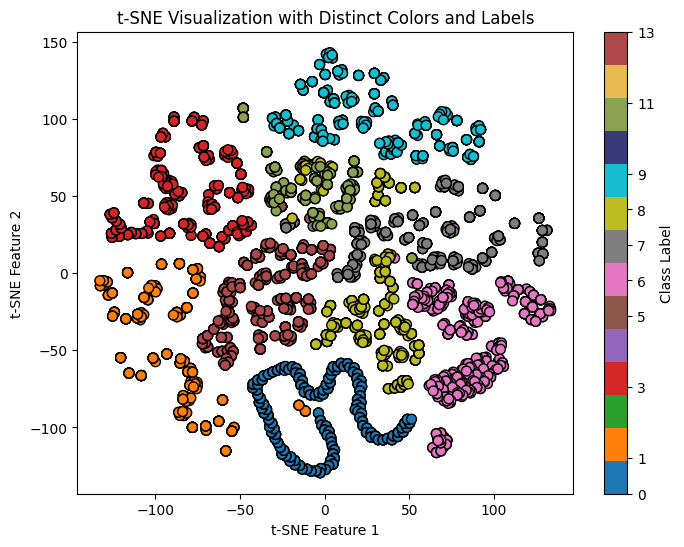

In [65]:

# Inizializza t-SNE con parametri aggiornati
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(vectors)

# Calcola i centroidi per ciascuna classe
unique_classes = np.unique(classes)
centroids = np.array([
    X_embedded[classes == label].mean(axis=0) for label in unique_classes
])

# Colori distinti e mappa dei colori
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
    '#393b79', '#8ca252', '#e7ba52', '#ad494a'
]
cmap = ListedColormap(colors[:14]) 

# Traccia i risultati
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=classes, cmap=cmap, s=50, alpha=1.0, edgecolor='k')

# Aggiungi etichette sul punto medio
'''
for i, centroid in enumerate(centroids):
    plt.text(centroid[0], centroid[1], str(unique_classes[i]),
             fontsize=12, fontweight='bold', ha='center', va='center', color='red',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
'''

# Aggiungi barra dei colori e label
plt.colorbar(scatter, label='Class Label', ticks=unique_classes)
plt.title('t-SNE Visualization with Distinct Colors and Labels')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()


In [72]:
output = model(image).squeeze().detach().cpu().numpy()
norm = np.max(output,axis=0).flatten()
classes = mask.flatten()

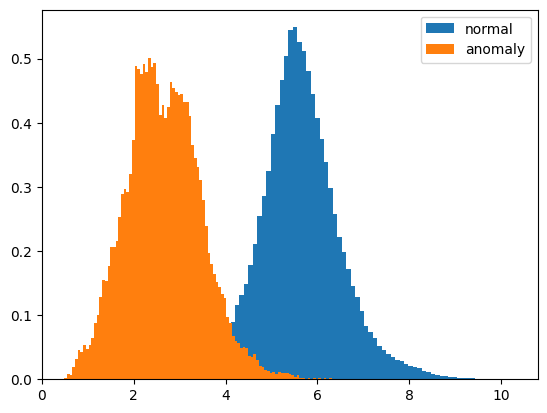

In [73]:
plt.hist(norm[classes!=13],bins=100,density=True,label='normal')
plt.hist(norm[classes==13],bins=100,density=True,label='anomaly')
plt.legend()
plt.show()